In [1]:
from datetime import datetime
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10 as dataset
from keras.utils import to_categorical
import tensorflow as tf

% matplotlib inline

Using TensorFlow backend.


# Set HyperParameter

In [0]:
#@title Set Hyperparameter { display-mode: "form", run: "auto" }
save_path = './weights/my_model'

image_shape = (32, 32, 3)
num_class = 10

learning_rate = 0.001  #@param [0.01, 0.001, 0.0001]
batch_size = 64  #@param [32, 64, 128]
num_epochs = 1  #@param {type:"slider", min:1, max:100, step:1}

drop_rate = 0.7

# VGG Model

학습 할 모델을 설계 해줍니다. 아래는 [VGG](https://arxiv.org/abs/1409.1556) [1] 모델을 예시로 하였습니다. 

**reference**  
[1] Karen Simonyan, Andrew Zisserman. "[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)". *arxiv:1409.1556*, 2014.

In [0]:
def conv_block(inputs, filters=64, kernel_size=(3, 3), strides=(1, 1), name='conv'):
    conv = tf.keras.layers.Conv2D(filters=filters,
                                  kernel_size=kernel_size,
                                  strides=strides,
                                  padding='SAME',
                                  name=name)(inputs)
    norm = tf.keras.layers.BatchNormalization()(conv)
    acts = tf.keras.layers.ReLU()(norm)
    return acts

def max_pooling(inputs, name='pool'):
    return tf.keras.layers.MaxPool2D(name=name)(inputs)


def build_model(input_shape):
    with tf.variable_scope("conv_layer"):
        inputs = tf.keras.layers.Input(input_shape)
        net = conv_block(inputs, filters=64, name='conv_1_1')
        net = conv_block(net, filters=64, name='conv_1_2')
        net = max_pooling(net, name='pool_1')

        net = conv_block(net, filters=128, name='conv_2_1')
        net = conv_block(net, filters=128, name='conv_2_2')
        net = max_pooling(net, name='pool_2')

        net = conv_block(net, filters=256, name='conv_3_1')
        net = conv_block(net, filters=256, name='conv_3_2')
        net = conv_block(net, filters=256, name='conv_3_3')
        net = max_pooling(net, name='pool_3')

        net = conv_block(net, filters=512, name='conv_4_1')
        net = conv_block(net, filters=512, name='conv_4_2')
        net = conv_block(net, filters=512, name='conv_4_3')
        net = max_pooling(net, name='pool_4')

        net = conv_block(net, filters=512, name='conv_5_1')
        net = conv_block(net, filters=512, name='conv_5_2')
        net = conv_block(net, filters=512, name='conv_5_3')
        net = max_pooling(net, name='pool_5')

    with tf.variable_scope("FC_layer"):
        net = tf.keras.layers.Flatten()(net)
        net = tf.keras.layers.Dense(4096, activation='relu')(net)
        net = tf.keras.layers.Dropout(drop_rate)(net)
        net = tf.keras.layers.Dense(4096, activation='relu')(net)
        net = tf.keras.layers.Dropout(drop_rate)(net)
        net = tf.keras.layers.Dense(num_class, activation='softmax')(net)
    return tf.keras.Model(inputs=inputs, outputs=net)

# Set Optimization

In [0]:
# Load DataSet
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()

categories = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [0]:
# Build Optimization for Model VGG
model = build_model(image_shape)
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.summary()

# Start Training

In [6]:
model.fit(x=train_images,
          y=to_categorical(train_labels, num_class),
          epochs=int(num_epochs),
          batch_size=int(batch_size),
          validation_data=(test_images, 
                           to_categorical(test_labels, num_class)),
         )

model.save_weights(save_path)
print("Model is Saved")

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 92s 2ms/step - loss: 2.3098 - acc: 0.1456 - val_loss: 2.3994 - val_acc: 0.1819
Model is Saved


# Evaluate Model

In [7]:
model.load_weights(save_path)
print("Model is loaded")
logits = model.predict(test_images, batch_size=32)
result = np.argmax(logits, -1)
print('Accuracy: %.4f' % np.mean(result == test_labels))

Model is loaded
Accuracy: 0.1000


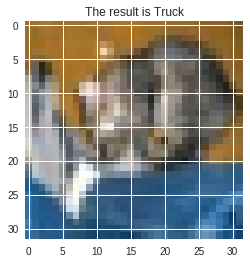

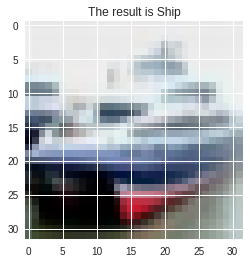

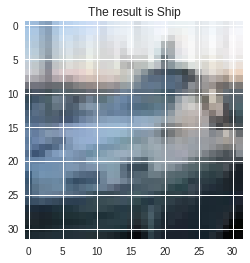

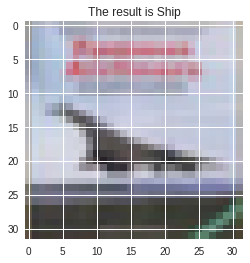

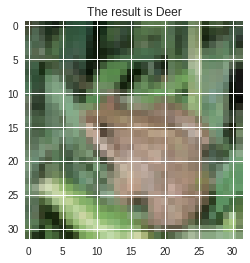

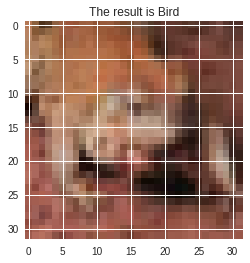

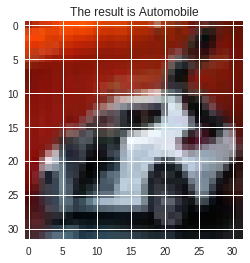

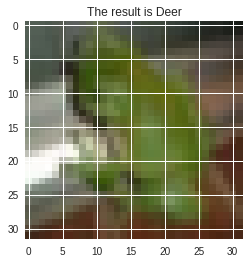

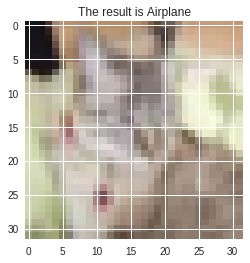

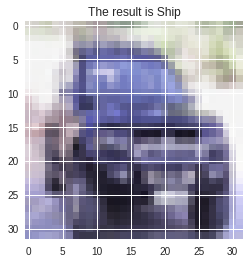

In [8]:
num_test = 10
for i in range(num_test):
    plt.title("The result is %s" % categories[result[i]])
    plt.imshow(test_images[i])
    plt.show()
    print('=' * 40)